# Preparando ambiente e Carregando o Dataset ✈
- Ir além: Utilização de Pyspark

In [1]:
!pip install pyspark

In [2]:
!pip install graphframes

In [3]:
!pip install imbalanced-learn

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, DoubleType
from imblearn.over_sampling import SMOTE
from pyspark.ml.linalg import Vectors
import plotly.express as px


# Criando Sessão Spark
spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

In [5]:
df = spark.read.csv("/content/train_transaction.csv", header=True, inferSchema=True)

# Análise Exploratoria Simples ⚛
- Para realizar visões com pyspark é necessário converter para pandas
- Utilizarei 10 porcento do dataset

In [50]:
# Porção de 10 porcento do dataset
sample_df = df.sample(False, 0.1, seed=42)
# Transformando para pandas
samples = sample_df.toPandas()

In [51]:
# Verificar colunas
samples.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

In [52]:
# Verificar correlações com as colunas numéricas
# Selecionando apenas as colunas numéricas
numeric_columns = samples.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = samples[numeric_columns].corr()

In [53]:
correlation_matrix

TransactionAmt     card2     card3     card5     addr1  \
TransactionAmt        1.000000  0.016897 -0.112565  0.005409 -0.007533   
card2                 0.016897  1.000000  0.020707  0.037615  0.028593   
card3                -0.112565  0.020707  1.000000 -0.153577 -0.006775   
card5                 0.005409  0.037615 -0.153577  1.000000  0.038428   
addr1                -0.007533  0.028593 -0.006775  0.038428  1.000000   
...                        ...       ...       ...       ...       ...   
V335                  0.045191  0.052177 -0.000669 -0.256434  0.027441   
V336                  0.103979  0.038574 -0.001624 -0.209606  0.017531   
V337                  0.159999 -0.005929  0.002594 -0.060843  0.011665   
V338                  0.118161  0.029330  0.002533 -0.199849  0.030178   
V339                  0.143359  0.014103  0.002582 -0.142916  0.022482   

                   addr2     dist1     dist2        C1        C2  ...  \
TransactionAmt  0.029466  0.027784  0.025620 -0.017662 -0.018029  ...   
card2          -0.022989 -0.012549  0.009889  0.006540  0.007754  ...   
card3          -0.592385 -0.030583 -0.166278  0.075222  0.086560  ...   
card5           0.036460  0.021600  0.029224 -0.011263 -0.013661  ...   
addr1           0.003478  0.008194  0.039365 -0.002388 -0.002449  ...   
...                  ...       ...       ...       ...       ...  ...   
V335            0.009277       NaN -0.057056  0.008461  0.006889  ...   
V336            0.010990       NaN -0.039960  0.025111  0.023732  ...   
V337            0.001262       NaN -0.016552 -0.001111 -0.001657  ...   
V338            0.003247       NaN -0.026061 -0.002750 -0.004383  ...   
V339            0.002517       NaN -0.022529 -0.003200 -0.004390  ...   

                    V330      V331      V332      V333      V334      V335  \
TransactionAmt  0.009769  0.043747  0.022385  0.034063  0.177085  0.045191   
card2           0.070212  0.046011  0.053988  0.053629  0.001188  0.052177   
card3           0.002596  0.001047  0.001108  0.001140 -0.004061 -0.000669   
card5          -0.280120 -0.229250 -0.252735 -0.258051 -0.057008 -0.256434   
addr1           0.036964  0.033339  0.036152  0.036981  0.001047  0.027441   
...                  ...       ...       ...       ...       ...       ...   
V335            0.816405  0.707093  0.797094  0.801835  0.469508  1.000000   
V336            0.639732  0.550539  0.612622  0.629272  0.719789  0.912128   
V337            0.182156  0.342613  0.253035  0.310544  0.048134  0.133188   
V338            0.662361  0.718355  0.727633  0.763256  0.119004  0.589920   
V339            0.474426  0.545065  0.502992  0.563894  0.118952  0.400799   

                    V336      V337      V338      V339  
TransactionAmt  0.103979  0.159999  0.118161  0.143359  
card2           0.038574 -0.005929  0.029330  0.014103  
card3          -0.001624  0.002594  0.002533  0.002582  
card5          -0.209606 -0.060843 -0.199849 -0.142916  
addr1           0.017531  0.011665  0.030178  0.022482  
...                  ...       ...       ...       ...  
V335            0.912128  0.133188  0.589920  0.400799  
V336            1.000000  0.114661  0.476851  0.343038  
V337            0.114661  1.000000  0.821258  0.945298  
V338            0.476851  0.821258  1.000000  0.950947  
V339            0.343038  0.945298  0.950947  1.000000  

[376 rows x 376 columns]

In [54]:
# Convertendo para mapa de calor plotly express

fig = px.imshow(correlation_matrix, text_auto=True)
fig.show()

In [55]:
# Para ficar mais visual, retirando as colunas vetores, que começam com V
numeric_columns = numeric_columns.drop(numeric_columns[numeric_columns.str.startswith('V')])

In [56]:
correlation_matrix = samples[numeric_columns].corr()
fig = px.imshow(correlation_matrix, text_auto=True)
fig.show()

In [57]:
# Verificar variações com boxplot plotly express
fig = px.box(samples, x="isFraud", y="TransactionAmt")
fig.show()

In [58]:
fig = px.box(samples, x="isFraud", y="card1", title="Boxplots")
fig.add_trace(px.box(samples, x="isFraud", y="card2").data[0])
fig.add_trace(px.box(samples, x="isFraud", y="card3").data[0])
fig.add_trace(px.box(samples, x="isFraud", y="card5").data[0])
fig.add_trace(px.box(samples, x="isFraud", y="dist1").data[0])
fig.add_trace(px.box(samples, x="isFraud", y="dist2").data[0])

# Atualizando o layout e mostrando o gráfico
fig.update_layout(showlegend=False)  # Esconde a legenda para evitar repetição
fig.show()

In [59]:
# Ver quantidade de valores nulos por colunas
samples.isnull().sum()

TransactionID         0
isFraud               0
TransactionDT         0
TransactionAmt        0
ProductCD             0
                  ...  
V335              50896
V336              50896
V337              50896
V338              50896
V339              50896
Length: 394, dtype: int64

In [60]:
samples['isFraud'].value_counts()

isFraud
0    57081
1     2081
Name: count, dtype: int64

## Conclusões da análise
Fica difícil identificar padrões com apenas 10 porcento do dataset e com colunas que não são possíveis saber os significados. Entretanto, será necessário tratar os valores nulos das colunas vetores. Os outliers encontrados nos boxplots, podem ser necessários para encontrar as fraudes. Além disso, como demostrado no value_counts das fraudes, existe um desbalanceamento

# Pré-Processamento ⏰
- Tratamentos
- Balanceamento com Undersampling
- Por motivos de processamento e aparentemente escalonamento já aplicado no dataset, não irei realizar o pré-processamento

In [6]:
df.printSchema()

root
 |-- TransactionID: integer (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- TransactionDT: integer (nullable = true)
 |-- TransactionAmt: double (nullable = true)
 |-- ProductCD: string (nullable = true)
 |-- card1: integer (nullable = true)
 |-- card2: double (nullable = true)
 |-- card3: double (nullable = true)
 |-- card4: string (nullable = true)
 |-- card5: double (nullable = true)
 |-- card6: string (nullable = true)
 |-- addr1: double (nullable = true)
 |-- addr2: double (nullable = true)
 |-- dist1: double (nullable = true)
 |-- dist2: double (nullable = true)
 |-- P_emaildomain: string (nullable = true)
 |-- R_emaildomain: string (nullable = true)
 |-- C1: double (nullable = true)
 |-- C2: double (nullable = true)
 |-- C3: double (nullable = true)
 |-- C4: double (nullable = true)
 |-- C5: double (nullable = true)
 |-- C6: double (nullable = true)
 |-- C7: double (nullable = true)
 |-- C8: double (nullable = true)
 |-- C9: double (nullable = true)
 |-- C10:

In [15]:
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
def optimized_clean_and_fill_na(df):
    # Obter o schema do DataFrame
    schema = df.schema

    # Separar colunas numéricas e de string
    numeric_cols = [f.name for f in schema.fields if isinstance(f.dataType, (IntegerType, DoubleType))]
    string_cols = [f.name for f in schema.fields if isinstance(f.dataType, StringType)]

    # Usando REGEX para limpeza e preenchimento
    numeric_exprs = [
        F.when(F.col(c).rlike('^[0-9.-]*$'), F.col(c).cast(schema[c].dataType)).otherwise(F.lit(None)).alias(c)
        for c in numeric_cols
    ]
    # String com Unkown
    string_exprs = [F.coalesce(F.col(c), F.lit('Unknown')).alias(c) for c in string_cols]

    # Aplicar todas as transformações de uma vez
    df = df.select(*numeric_exprs, *string_exprs, *[F.col(c) for c in df.columns if c not in numeric_cols and c not in string_cols])

    # Preencher NAs numéricos com 0
    df = df.fillna(0, subset=numeric_cols)

    return df


In [16]:
df_filled = optimized_clean_and_fill_na(df)

In [17]:
# Undersampling
major = df_filled.filter(df_filled.isFraud == 0)
minor = df_filled.filter(df_filled.isFraud == 1)

major_count = major.count()
minor_count = minor.count()

ratio = major_count / minor_count
print(ratio)


27.579586700866283


In [18]:
# Aplicando undersampling
sampled_major = major.sample(False, 1 / ratio)
df_balanced = sampled_major.unionAll(minor)

In [48]:
# Tamanho do dataset balanceado
df_balanced.count()

41547

In [49]:
# Quantidade de cada classe
df_balanced.groupBy('isFraud').count().show()

+-------+-----+
|isFraud|count|
+-------+-----+
|      0|20884|
|      1|20663|
+-------+-----+



### Corrijindo erro 'W'

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

In [35]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
def preprocess_data(X, y):
    # Converter X para DataFrame se não for
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)

    # Identificar colunas categóricas
    categorical_columns = X.select_dtypes(include=['object']).columns

    # Aplicar LabelEncoder para cada coluna categórica
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

    # Converter X e y para numpy arrays
    X = X.to_numpy().astype(np.float32)
    y = y.astype(np.float32)

    return X, y, label_encoders

In [20]:
df_pandas = df_balanced.toPandas()

In [21]:
df_pandas.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object', length=394)

# Modelagem ⚓
- Preparação dos dados para treinamento
- Arquitetura do Modelo
- Treino
- Avaliação das Métricas

In [22]:
X = df_pandas.drop('isFraud', axis=1)
y = df_pandas['isFraud']

### Criando Sequência

In [33]:
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(target[i + sequence_length])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [36]:
# Pré-processamento dos dados
X, y, label_encoders = preprocess_data(X, y)

# Criação das sequências
sequence_length = 10
X_seq, y_seq = create_sequences(X, y, sequence_length)

In [37]:
#Dividindo os dados
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [38]:
# Arquitetura
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, X.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
# Treino do modelo e validação
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Modelo
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Epoch 1/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5114 - loss: 0.6943 - val_accuracy: 0.5324 - val_loss: 0.6906
Epoch 2/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5306 - loss: 0.6895 - val_accuracy: 0.5293 - val_loss: 0.6905
Epoch 3/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5252 - loss: 0.6893 - val_accuracy: 0.5287 - val_loss: 0.6921
Epoch 4/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5328 - loss: 0.6882 - val_accuracy: 0.5265 - val_loss: 0.6875
Epoch 5/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5254 - loss: 0.6878 - val_accuracy: 0.5325 - val_loss: 0.6868
Epoch 6/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5289 - loss: 0.6871 - val_accuracy: 0.5314 - val_loss: 0.6865
Epoch 7/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5301 - loss: 0.6875 - val_accuracy: 0.5348 - val_loss: 0.6848
Epoch 8/10
831/831 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5284 - loss: 0.6867 - val_accuracy: 0

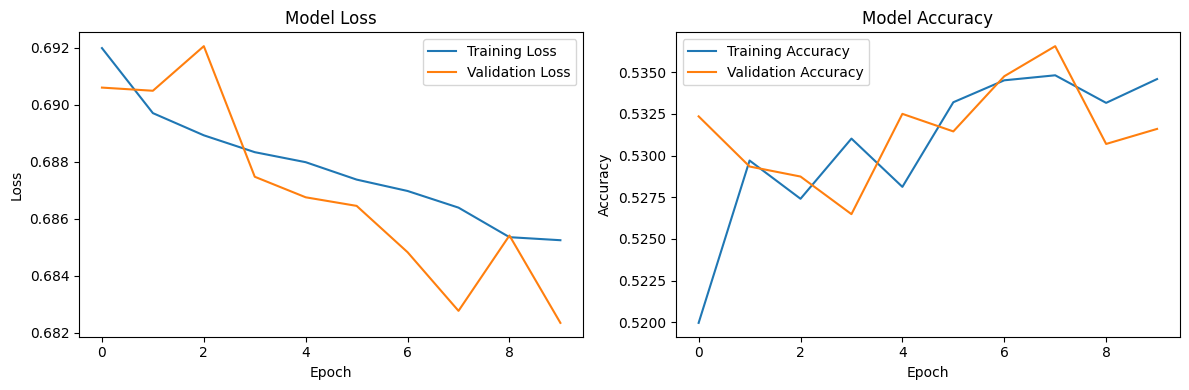

In [41]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

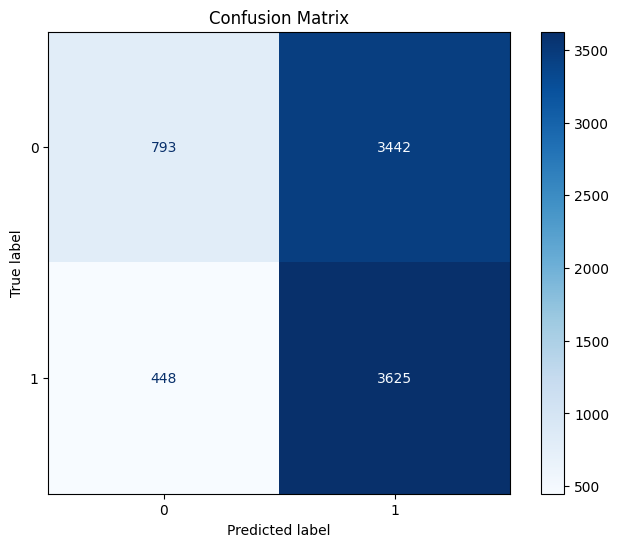

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Documentação do Modelo

## 1. Criando Sequências Temporais

```python
def create_sequences(data, target, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(target[i + sequence_length])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

sequence_length = 10
X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)
```

- A função `create_sequences` é definida para gerar sequências temporais a partir dos dados.
- Ela cria sequências de tamanho 10 (ajustável) a partir das features escaladas.
- Cada sequência está associada ao valor alvo que a segue.

## 2. Divisão dos Dados

```python
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
```

- Os dados são divididos em conjuntos de treino (80%) e teste (20%).
- Um estado aleatório (`random_state`) é definido para reprodutibilidade.

## 3. Arquitetura do Modelo LSTM

```python
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, X.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
```

A arquitetura do modelo consiste em:

1. Uma camada LSTM com 64 unidades, retornando sequências para a próxima camada LSTM.
2. Uma camada de Dropout (taxa de dropout de 20%) para regularização.
3. Outra camada LSTM com 32 unidades.
4. Outra camada de Dropout (taxa de dropout de 20%).
5. Uma camada Dense com 16 unidades e ativação ReLU.
6. Uma camada Dense final com 1 unidade e ativação sigmoid para classificação binária.

## 4. Compilação do Modelo

```python
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
```

- O modelo utiliza o otimizador Adam com uma taxa de aprendizado de 0.001.
- A função de perda utilizada é a entropia cruzada binária (`binary_crossentropy`), apropriada para classificação binária.
- A acurácia (`accuracy`) é monitorada como métrica durante o treinamento.

## 5. Treinamento e Validação do Modelo

```python
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
```

- O `early stopping` (parada antecipada) é implementado para evitar overfitting.
- O modelo é treinado por no máximo 100 épocas com um tamanho de lote (`batch size`) de 32.
- 20% dos dados de treinamento são usados para validação.
- O histórico do treinamento é armazenado para análise posterior.

## 6. Avaliação do Modelo

```python
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
```

- O modelo é avaliado no conjunto de teste.
- As previsões são feitas e convertidas para valores binários (0 ou 1) usando um limite de 0.5.
- Diversas métricas são calculadas:

- **Acurácia**: Correção geral do modelo
- **Recall**: Capacidade de encontrar todas as instâncias positivas
- **F1-score**: Média harmônica de precisão e recall
- **AUC-ROC**: Capacidade do modelo de distinguir entre classes

## 7. Análise dos Resultados

```python
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()
```

- Dois gráficos são gerados para visualizar o desempenho do modelo durante o treinamento:

1. **Perda do Modelo**: Compara a perda de treinamento e validação ao longo das épocas.
2. **Acurácia do Modelo**: Compara a acurácia de treinamento e validação ao longo das épocas.

- Os gráficos ajudam a identificar problemas de overfitting ou underfitting.

# Conclusões acerca dos resultados

## Acerca das Métricas
- Alta taxa de Recall: O modelo é bom em identificar casos positivos, o que pode ser útil se o custo de falsos negativos for alto.
- Baixa Precisão: Observando a matriz de confusão, vemos um alto número de falsos positivos (3442), indicando que o modelo tende a classificar muitos casos negativos como positivos.
- Baixa Acurácia e AUC-ROC: Sugerem que o modelo tem dificuldade em distinguir corretamente entre as classes.

## Acerca de um possível Under/Overfitting:
Baseado nas métricas e na curva de aprendizado:

- Não parece haver overfitting significativo, já que o desempenho no conjunto de teste não é muito inferior ao esperado.
- Pode haver um leve underfitting, dado o desempenho geral moderado (acurácia de 0.5318 e AUC-ROC de 0.5502).

## Considerações:
- O Possível Underfitting pode se dar ao fato de eu rodar apenas 10 épocas
- Houve bastante dificuldade no processamento das colunas e pré-processamento em algumas strings embutidas em colunas numéricas
- Apenas o dataset das transações de treinos, não garantém que são uma sequência, já que não existe data e nem id originário(cliente) das transações por exemplo. O que pode resultar na pessíma acurácia
